[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 977 out of 1000 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


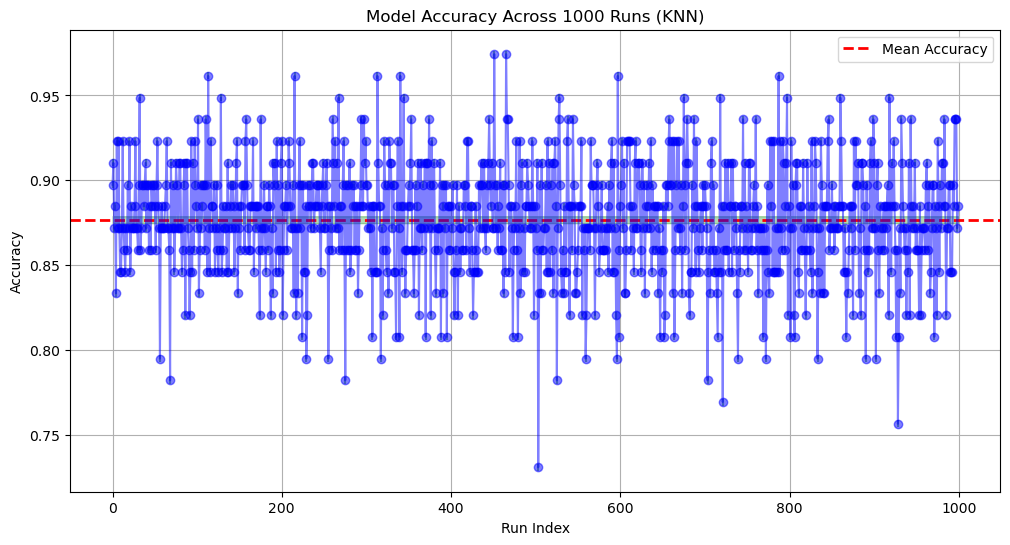

Mean Accuracy: 0.876769230769231


In [15]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score

# Read in data
data = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Replace missing values in 'Sleep Disorder' with 'None' (explicitly modify original DataFrame)
data.loc[data['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Convert classes to numbers
genders = ["Male", "Female"]
bmis = ["Normal", "Normal Weight", "Overweight", "Obese"]

for i in range(len(data)):
    data.at[i, "Gender"] = genders.index(data.at[i, "Gender"])
    data.at[i, "BMI Category"] = bmis.index(data.at[i, "BMI Category"])
    data.at[i, "BP top"] = data.at[i, "Blood Pressure"][:data.at[i, "Blood Pressure"].find("/")]
    data.at[i, "BP bottom"] = data.at[i, "Blood Pressure"][data.at[i, "Blood Pressure"].find("/") + 1:]

# Set NAs to None
data.loc[data['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Map Sleep Disorder to numerical values (None: 0, Sleep Apnea: 1, Insomnia: 2)
sleep_disorder_mapping = {'None': 0, 'Sleep Apnea': 1, 'Insomnia': 2}
data['Sleep Disorder'] = data['Sleep Disorder'].replace(sleep_disorder_mapping)

# Split positive and negative
positive = data.loc[data['Sleep Disorder'] != 0]
negative = data.loc[data['Sleep Disorder'] == 0]

# Sample each group equally
smallPos = positive.sample(n=155, random_state=1)
smallNeg = negative.sample(n=155, random_state=1)

# Combine samples and randomize
test = pd.concat([smallPos, smallNeg])
test = test.sample(frac=1, random_state=3)

# Select important columns
X = test[["Gender", "Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BP top", "BP bottom", "BMI Category", "Heart Rate"]]
y = test['Sleep Disorder']

# Number of neighbors
k = 6

# Number of parallel runs
n_runs = 1000

# Function to train and evaluate the Gradient Boosting model
def train_and_evaluate_model(seed):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

    # Initialize and train the Gradient Boosting model
    model = Pipeline(
                steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))]
            )
    # Example parameters
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run the Gradient Boosting model multiple times in parallel
results = Parallel(n_jobs=-1, verbose=1)(delayed(train_and_evaluate_model)(seed) for seed in range(n_runs))

# Convert results to numpy array
results_array = np.array(results)

# Calculate mean and confidence interval
mean_accuracy = np.mean(results_array)
std_deviation = np.std(results_array)
margin_of_error = 1.96 * (std_deviation / np.sqrt(n_runs))  # 95% confidence interval

# Create indices for the runs
indices = np.arange(n_runs)

# Plot the mean accuracy with confidence interval using error bars
plt.figure(figsize=(12, 6))
plt.errorbar(indices, results_array, yerr=margin_of_error, fmt='o', linestyle='-', color='b', ecolor='g', alpha=0.5)
plt.fill_between(indices, mean_accuracy - margin_of_error, mean_accuracy + margin_of_error, color='g', alpha=0.3)
plt.axhline(mean_accuracy, color='red', linestyle='dashed', linewidth=2, label='Mean Accuracy')
plt.xlabel('Run Index')
plt.ylabel('Accuracy')
plt.title(f'Model Accuracy Across {n_runs} Runs (KNN)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean Accuracy: {mean_accuracy}")


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Parameters: {'n_neighbors': 5}
Best Accuracy: 0.8875
Test Accuracy: 0.8548387096774194


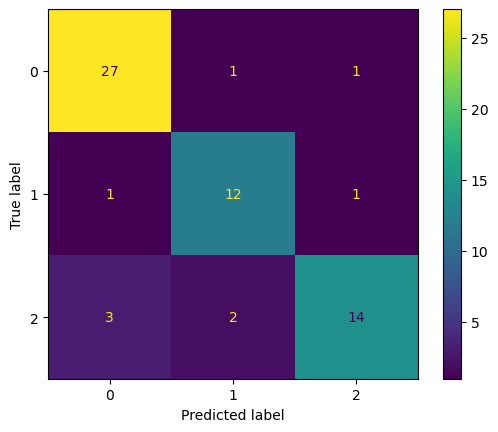

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read in data
data = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

# Replace missing values in 'Sleep Disorder' with 'None' (explicitly modify original DataFrame)
data.loc[data['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Convert classes to numbers
genders = ["Male", "Female"]
bmis = ["Normal", "Normal Weight", "Overweight", "Obese"]

for i in range(len(data)):
    data.at[i, "Gender"] = genders.index(data.at[i, "Gender"])
    data.at[i, "BMI Category"] = bmis.index(data.at[i, "BMI Category"])
    data.at[i, "BP top"] = data.at[i, "Blood Pressure"][:data.at[i, "Blood Pressure"].find("/")]
    data.at[i, "BP bottom"] = data.at[i, "Blood Pressure"][data.at[i, "Blood Pressure"].find("/") + 1:]

# Set NAs to None
data.loc[data['Sleep Disorder'].isna(), 'Sleep Disorder'] = 'None'

# Map Sleep Disorder to numerical values (None: 0, Sleep Apnea: 1, Insomnia: 2)
sleep_disorder_mapping = {'None': 0, 'Sleep Apnea': 1, 'Insomnia': 2}
data['Sleep Disorder'] = data['Sleep Disorder'].replace(sleep_disorder_mapping)

# Split positive and negative
positive = data.loc[data['Sleep Disorder'] != 0]
negative = data.loc[data['Sleep Disorder'] == 0]

# Sample each group equally
smallPos = positive.sample(n=155, random_state=1)
smallNeg = negative.sample(n=155, random_state=1)

# Combine samples and randomize
test = pd.concat([smallPos, smallNeg])
test = test.sample(frac=1, random_state=3)

# Select important columns
X = test[["Gender", "Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "BP top", "BP bottom", "BMI Category", "Heart Rate"]]
y = test['Sleep Disorder']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(5, 35))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=best_model.classes_)
disp.plot()
plt.show()

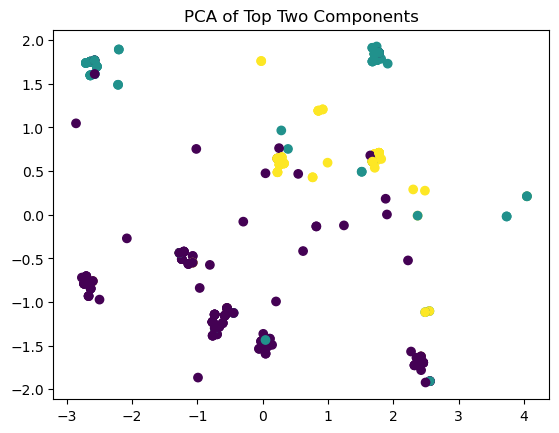

Explained variance ratio: [0.51449056 0.24995089]


In [7]:
# import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets, decomposition

# Assuming df_subset contains your dataset after preprocessing
# Define features (X) and target variable (y)
X = test[['Age', 'Sleep Duration', 'Stress Level', 'Physical Activity Level', 'Quality of Sleep', 'BMI Category']]  # Features
y = test['Sleep Disorder']  # Target variable

# Standardize the feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA with 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA-reduced data
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title('PCA of Top Two Components')
plt.show()

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
